In [1]:
import numpy as np
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import shapely.geometry as sg
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json
import utils.toolshelf as t
import LagrangianDEMdifferencing.utils.lagrange as lagrange
from random import sample

import fiona

warnings.filterwarnings('ignore')
%matplotlib inline

/tmp/ipykernel_114/3536755958.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# # Select predetermined track (2 digit cycle number)
site = "filchnerF1"
cycleList = [12, 14, 16]

# Data access options
# (-1: Skip altogether, 0: process fresh, 1: load from geojson, 2: load from csv)
accessType = 1

#input options
# resolution (recommended 20.0)
# "len" and "res" (will be equal)
res = 10.0
cnf = 2

#output options
# Save flag (0: dont save, 1: save as geojson (slow but everything works), 
# 2: save as csv (faster but nothing works))
sFlag = 1

In [3]:
# gt dictionary
global gtDict, revgtDict, geoidDefault, cycleDict
gtDict = {"gt1l": 10, "gt1r": 20, "gt2l": 30, "gt2r": 40, "gt3l": 50, "gt3r": 60}
revgtDict = {10: "gt1l", 20: "gt1r", 30: "gt2l", 40: "gt2r", 50: "gt3l", 60: "gt3r"}
geoidDefaultDict = {'ross1': -55.5, 'filchnerF1': -14.45734}
geoidDefault = geoidDefaultDict[site]
melangeCutoffDict = {'ross1': 30, 'filchnerF1': 60}
min_photonDict = {'ross1': 200, 'filchnerF1': 200}

#cycle start and end dates
cycleDict = {'01': ['2018-10-13', '2018-12-28'], '02': ['2018-12-28', '2019-03-29'], 
             '03': ['2019-03-29', '2019-06-28'], '04': ['2019-07-09', '2019-09-26'], 
             '05': ['2019-09-26', '2019-12-26'], '06': ['2019-12-26', '2020-03-26'],
             '07': ['2020-03-26', '2020-06-25'], '08': ['2020-06-25', '2020-09-24'],
             '09': ['2020-09-24', '2020-12-23'], '10': ['2020-12-24', '2021-03-24'],
             '11': ['2021-03-24', '2021-06-23'], '12': ['2021-06-23', '2021-09-22'],
             '13': ['2021-09-22', '2021-12-22'], '14': ['2021-12-22', '2022-03-23'],
             '15': ['2022-03-23', '2022-06-21'], '16': ['2022-06-21', '2022-09-20'],
             '17': ['2022-09-20', '2022-12-20'], '18': ['2022-12-20', '2023-03-21'],
             '19': ['2023-03-21', '2023-06-20'], '20': ['2023-06-20', '2023-09-19'],
             '21': ['2023-09-19', '2023-12-18'], '22': ['2023-12-18', '2024-03-18']}


cycleMonthDict = {'01': ['Oct', 'Dec'], '02': ['Dec', 'Mar'], 
             '03': ['Mar', 'Apr'], '04': ['Jun', 'Sep'], 
             '05': ['Sep', 'Dec'], '06': ['Dec', 'Mar'],
             '07': ['Mar', 'Jun'], '08': ['Jun', 'Sep'],
             '09': ['Sep', 'Dec'], '10': ['Dec', 'Mar'],
             '11': ['Mar', 'Jun'], '12': ['Jun', 'Sep'],
             '13': ['Sep', 'Dec'], '14': ['Dec', 'Mar'],
             '15': ['Mar', 'Jun'], '16': ['Jun', 'Sep'],
             '17': ['Sep', 'Dec'], '18': ['Dec', 'Mar'],
             '19': ['Mar', 'Jun'], '20': ['Jun', 'Sep'],
             '21': ['Sep', 'Dec'], '22': ['Dec', 'Mar']}

'''
File Naming Conventions
ATL[xx]_[yyyymmdd][hhmmss]_[tttt][cc][nn]_[vvv]_[rr].h5
xx : ATLAS product number
yyyymmdd : year, month and day of data acquisition
hhmmss : start time, hour, minute, and second of data acquisition
tttt : Reference Ground Track (RGT, ranges from 1–1387)
cc : Orbital Cycle (91-day period)
nn : Granule number (ranges from 1–14)
vvv : data version number
rr : data release number
'''

# Import granule id, 
def unpackGranuleID(gid):
    #global shortName, dat, tim, rgt, cycle, granuleNumber, version, release
    granID = gid[:]
    gid = gid.split('_')
    shortName = f'{gid[0]}'
    dat = f'{gid[1][0:4]}-{gid[1][4:6]}-{gid[1][6:8]}'
    tim = f'{gid[1][8:10]}:{gid[1][10:12]}:{gid[1][12:14]}'
    rgt = int(f'{gid[2][0:4]}')
    cycle = int(f'{gid[2][4:6]}')
    granuleNumber = int(f'{gid[2][6:8]}')
    version = int(f'{gid[3]}')
    release = int(f'{gid[4][0:2]}')
    return {"shortName": shortName, "date": dat, "time": tim, 
            "rgt": rgt, "cycle": cycle, "granuleNumber": granuleNumber, 
            "version": version, "release": release, "granuleID": granID}

# Get a datetime formatted for earthdata cmr search from geodataframe timestamp
def getDateTime(timestp):
    dat, tim = timestp.date(), timestp.time().strftime("%H:%M:%S")
    return f"{dat}T{tim}Z"

def displayInfo(gdf):
    print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
    print("Beams: {}".format([revgtDict[b] for b in list(gdf['gt'].unique())]))
    print("Cycles: {}".format(gdf["cycle"].unique()))
    print("Received {} elevations".format(gdf.shape[0]))
    print(f"Across {3*(len(np.unique(gdf.loc[:, 'rgt'])) + len(np.unique(gdf.loc[:, 'cycle'])))} strong tracks")
    # Exception here is only necessary when importing csv's
    try: print(f"Date range {gdf.index.min().date()} to {gdf.index.max().date()}")
    except: print(f"Date range {datetime.strptime(gdf.index.min()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}" 
        f" to {datetime.strptime(gdf.index.max()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}")
    print(f"Vertical range {gdf.h_mean.min()}m to {gdf.h_mean.max()}m")
    return

def display03Info(gdf):
    print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
    #print("Beams: {}".format([revgtDict[b] for b in list(atl06_sr['gt'].unique())]))
    print("Spots: {}".format(gdf["spot"].unique()))
    print("Cycles: {}".format(gdf["cycle"].unique()))
    print("Received {} elevations".format(gdf.shape[0]))
    print(f"Across {3*(len(np.unique(gdf.loc[:, 'rgt'])) + len(np.unique(gdf.loc[:, 'cycle'])))} strong tracks")
    # Exception here is only necessary when importing csv's
    try: print(f"Date range {gdf.index.min().date()} to {gdf.index.max().date()}")
    except: print(f"Date range {datetime.strptime(gdf.index.min()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}" 
        f" to {datetime.strptime(gdf.index.max()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}")
    return

def getTrackList(gdf, min_photons=200, print_lens=False, verbose=True):
    rgtAll = atl06_sr["rgt"].unique()
    gtAll = atl06_sr['gt'].unique()
    cycleAll = atl06_sr["cycle"].unique()
    lens = []
    tracks=[]

    for cyc in cycleAll:
        #t = atl06_sr[atl06_sr.cycle==cyc]
        for r in rgtAll:
            #t = t[t.rgt==r]
            for g in gtAll:
                t = atl06_sr[(atl06_sr.cycle==cyc)*(atl06_sr.rgt==r)*(atl06_sr.loc[:, 'gt']==g)]
                if len(t)>min_photons:
                    tracks.append((cyc, r, revgtDict[g]))
                    lens.append(len(t))
    if print_lens: print(lens)
    if verbose:
        print(f'Finding tracks with minimum of {min_photons} photons')
        print(f'{len(lens)} found')
    return tracks

def getTrack(dat, trackInfo):
    cycle, rgt, gt = trackInfo[0], trackInfo[1], gtDict[trackInfo[2]]
    track = dat[(dat.rgt==rgt)*(dat.cycle==cycle)*(dat.loc[:, 'gt']==gt)]
    return track, cycle, rgt, gt

def geoCorrect(dat):
    # Geo correct atl03 data
    return dat['height']-dat['geoid']

 
#Save elevations
def saveMelange(dat):
    datReduced = dat.loc[:, ['cycle', 'rgt', 'spot', 'h_mean', 'geometry']]
    datReduced.to_file(f"{filenameMel}.geojson", driver='GeoJSON')
    return



In [4]:
atl06_sr_list = []
melange_sr_list = []

for cycle in cycleList:
    
    shpPath = f"../shapes/{site}/{site}_{cycle}.geojson"

    datPath = f"../data/"
    figPath = f"../figs/{site}/"
    filename03 = f"{datPath}{site}_ATL03_def"
    filename06 = f"{datPath}{site}_res{int(res)}/{site}_ATL06_cyc{cycle}_res{int(res)}"
    filenameMel = f"{datPath}{site}_melange/{site}_mel_cyc{cycle}_res{int(res)}"

    # Load all data
    print('Downloading atl06-SR data upload from .geojson file')
    atl06_sr = gpd.read_file(f"{filename06}.geojson").set_index('time')
    
    trackList = getTrackList(atl06_sr, min_photons=min_photonDict[site], print_lens=False)
    ss_atl06_sr = pd.concat([getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList])
    
    ss_atl06_sr.h_mean -= geoidDefault
    # filchner1 -5, 100
    ss_atl06_sr = ss_atl06_sr[(ss_atl06_sr.h_mean<100)*(ss_atl06_sr.h_mean>-5)]
    
    atl06_sr_list.append(ss_atl06_sr)
    
    melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<melangeCutoffDict[site]]
    melange_sr_list.append(melange_sr)
    displayInfo(atl06_sr)
    
    print('_________________________________________________')

Finding tracks with minimum of 200 photons
37 found
Reference Ground Tracks: [ 109  231  253  292  314  436  551  612  756  817  878  993 1054 1115
 1176 1259]
Beams: ['gt3l', 'gt2l', 'gt1l']
Cycles: [12]
Received 18744 elevations
Across 51 strong tracks
Date range 2021-06-30 to 2021-09-14
Vertical range -7.468781619226893m to 76.26257430459894m
_________________________________________________
Finding tracks with minimum of 200 photons
20 found
Reference Ground Tracks: [ 170  231  253  314  878  993 1054 1115 1176 1198]
Beams: ['gt3r', 'gt2r', 'gt1r']
Cycles: [14]
Received 9553 elevations
Across 33 strong tracks
Date range 2022-01-02 to 2022-03-10
Vertical range -3.9172990785304544m to 354.46882168577963m
_________________________________________________
Finding tracks with minimum of 200 photons
45 found
Reference Ground Tracks: [ 109  170  231  253  292  314  375  612  673  734  756  817  878  993
 1054 1115 1198 1259 1320]
Beams: ['gt3l', 'gt2l', 'gt1l']
Cycles: [16]
Received 22297

In [5]:
commonRGTs = [231, 253, 292, 314, 878, 993, 1054, 1115]
commonBeams = ['gt3', 'gt2', 'gt1']

rgt = sample(commonRGTs, 1)[0]
beam = sample(commonBeams, 1)[0]
print(f'track {rgt}-{beam}')

track 292-gt3


12
14
16


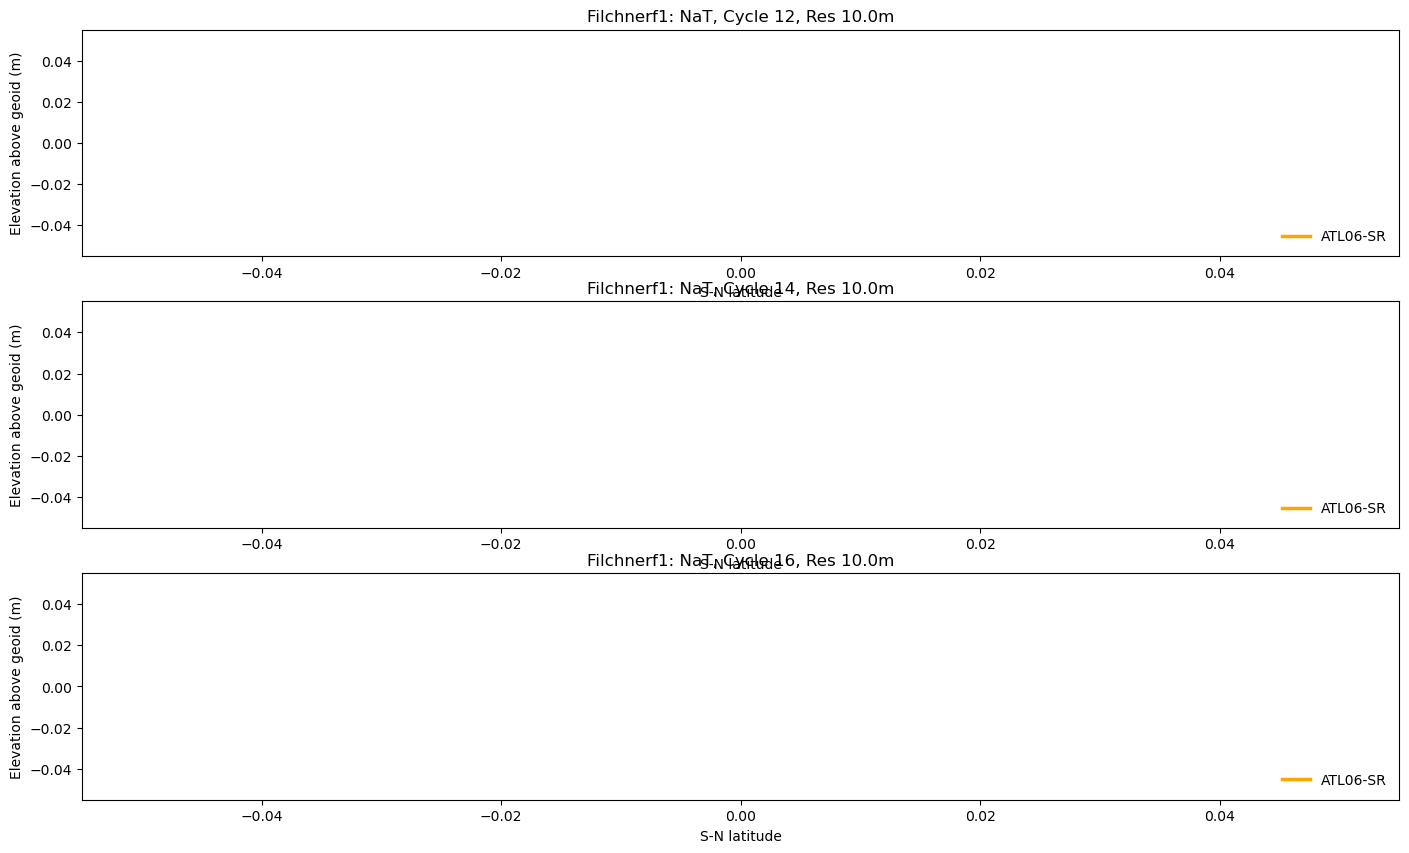

In [6]:
#Plot stuff
fig, ax = plt.subplots(3, 1, figsize=[17, 10])

for i in range(3):
    if i==0: gt, beamName = gtDict[f'{beam}l'], f'{beam}l'
    if i==1: gt, beamName = gtDict[f'{beam}r'], f'{beam}r'
    if i==2: gt, beamName = gtDict[f'{beam}l'], f'{beam}l'
    
    cycle = cycleList[i]
    print(cycle)
    track, cycle, rgt, gt = getTrack(atl06_sr_list[i], (cycle, rgt, beamName))
    mTrack, cycle, rgt, gt = getTrack(melange_sr_list[i], (cycle, rgt, beamName))
    dat = track.index.min().date()
    
    titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
    xlab = 'S-N latitude'
    ylab = 'Elevation above geoid (m)'
    yl = None#[-8, 60]
    xl=None
    
    x = track.geometry.y
    y = track.h_mean
    
    ax[i].plot(x, y, '-', color='orange', linewidth=2.5, label='ATL06-SR')
    
    x = mTrack.geometry.y
    y = mTrack.h_mean
    
    ax[i].plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
    
    #N = len(y)
    #rms = np.sqrt(np.mean(y**2)/(N-1))
    #m = np.mean(y)

    
    #ax[i].axhline(y=m, color='red', linewidth=1)
    #ax[i].axhline(y=m+rms, color='lightblue', linewidth=1)
    #ax[i].axhline(y=m-rms, color='lightblue', linewidth=1)
    ax[i].set_title(titl)
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel(ylab)
    ax[i].set_ylim(yl)
    ax[i].set_xlim(xl)
    
    ax[i].legend(loc=4, frameon=False)
    
    info = f'ICESat-2 track {rgt}-{beam}'

12
14
16


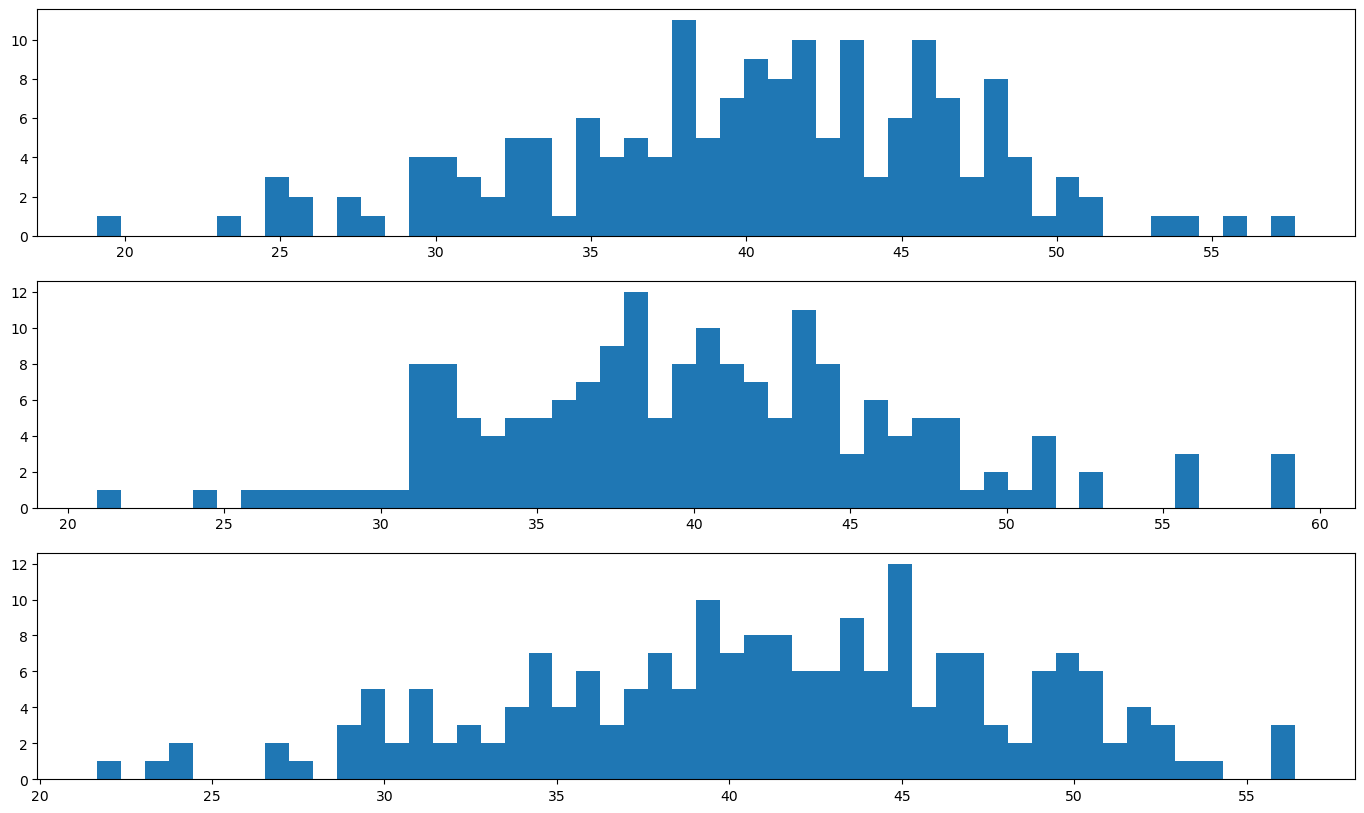

In [171]:



fig, ax = plt.subplots(3, 1, figsize=[17, 10])

for i in range(3):
    if i==0: gt, beamName = gtDict[f'{beam}l'], f'{beam}l'
    if i==1: gt, beamName = gtDict[f'{beam}r'], f'{beam}r'
    if i==2: gt, beamName = gtDict[f'{beam}l'], f'{beam}l'
    
    cycle = cycleList[i]
    print(cycle)
    track, cycle, rgt, gt = getTrack(atl06_sr_list[i], (cycle, rgt, beamName))
    mTrack, cycle, rgt, gt = getTrack(melange_sr_list[i], (cycle, rgt, beamName))
    dat = track.index.min().date()
    
    titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
    xlab = 'S-N latitude'
    ylab = 'Elevation above geoid (m)'
    yl = None#[-8, 60]
    xl=None
    
    y = mTrack.h_mean
    
    ax[i].hist(y, 50)
    #ax[i].set_ylim([0, 80])
    
    info = f'ICESat-2 track {rgt}-{beam}'

In [110]:
getTrack(atl06_sr_list[1], (14, 314, 'gt2l'))

(Empty GeoDataFrame
 Columns: [rgt, n_fit_photons, rms_misfit, dh_fit_dx, distance, spot, gt, w_surface_window_final, cycle, dh_fit_dy, h_sigma, pflags, segment_id, h_mean, geometry]
 Index: [],
 14,
 314,
 30)

In [111]:
atl06_sr_list[1].loc[:, 'gt'].unique()

array([60, 40, 20])

In [88]:
track

,rgt,n_fit_photons,rms_misfit,dh_fit_dx,distance,spot,gt,w_surface_window_final,cycle,dh_fit_dy,h_sigma,pflags,segment_id,h_mean,geometry
time,,,,,,,,,,,,,,,


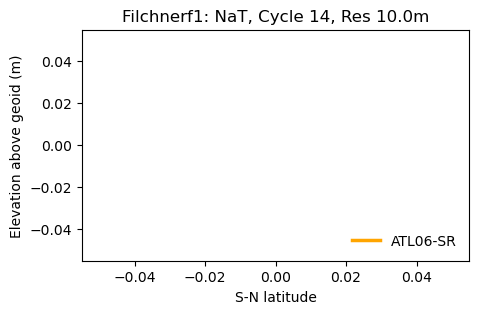

In [85]:
fig, ax = plt.subplots(figsize=[5, 3])

cycle = 14
track, cycle, rgt, gt = getTrack(atl06_sr_list[2], (cycle, rgt, beam))
#mTrack, cycle, rgt, gt = getTrack(melange_sr[2], (cycle, rgt, beam))
dat = track.index.min().date()

titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
xlab = 'S-N latitude'
ylab = 'Elevation above geoid (m)'
yl = None#[-8, 60]
xl=None

x = track.geometry.y
y = track.h_mean

ax.plot(x, y, '-', color='orange', linewidth=2.5, label='ATL06-SR')

#x = mTrack.geometry.y
#y = mTrack.h_mean

ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
ax.set_title(titl)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.set_ylim(yl)
ax.set_xlim(xl)

ax.legend(loc=4, frameon=False)

info = f'ICESat-2 track {rgt}-{beam}'

In [ ]:
# Plotting stuff
def plot06(track, save=False, titl='ATL06 Data', xlab='S-N latitude', ylab='Elevation above geoid (m)',
          xl=None, yl=None):
    try:
        fig, ax = plt.subplots(figsize=[15, 3])

        x = (track['distance']-track['distance'][0])/1000
        x = track.geometry.y
        y = track.h_mean
        if not isSeaward:
            print("Track should be reversed to seaward orientation")
            #x = (track['distance']-(track['distance'][-1]))/1000
        ax.plot(x, y, '-', color='orange', linewidth=2.5, label='ATL06-SR')

        x = (mTrack['distance']-track['distance'][0])/1000
        x = mTrack.geometry.y
        y = mTrack.h_mean
        ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
        ax.set_title(titl)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.set_ylim(yl)
        ax.set_xlim(xl)
        ax.legend(loc=4, frameon=False)
        info = f'ICESat-2 track {rgt}-{revgtDict[gt]}'
        plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
                 transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
        if save:
            plt.savefig(f'{figPath}melange/{site}_cyc{cycle}_rgt{rgt}-{revgtDict[gt][-2:]}_res{res}_mel.png', 
                        dpi=150, bbox_inches='tight')
            
    except: print(f"something went wrong with this track")
   